In [2]:
# import exportnb
# exportnb.export_notebooks(['./210618 - Functions_for_import.ipynb'])
import setup

In [3]:
import numpy as np
import os.path
from numpy import pi, floor, sqrt
import scipy.sparse as sp
import scipy.sparse.linalg
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

In [22]:
styles = ['science']
prefix = '../stylelib/'
sufix = '.mplstyle'
for i in range(len(styles)):
    styles[i] = prefix + styles[i] + sufix
plt.style.use(styles)
plt.rcParams.update({'font.size': 20, 'text.usetex': False})

# Evolution + control

In [5]:
from numpy import pi as π

def Trotter_solver_dynamics(time,v0,control,g1=None,g2=None):
    vt = [v0]
    last_t = time[0]
    for t in time[1:]:
        dt = t - last_t
        v0 = scipy.sparse.linalg.expm_multiply((-1j*dt) * control.Hamiltonian(g1=g1(t), g2=g2(t)), v0)
        vt.append(v0)
        last_t = t
    return np.array(vt).T

def gt1(t, σ, κ):
    if σ == 0.5*κ:
        return σ / np.cosh(σ*t)
    th = np.tanh(t*σ)
    ex = np.exp(-2*t*σ)
    return (κ - 2*σ*th)/np.sqrt(2*(κ*(1+ex)-2*σ)/σ)

## Unifying ideas for the protocol

Given a matrix $U$ we define the minimum fidelity with respect to the ideal gate $U_{id}$ as
$$F = \mathrm{min} \frac{\left|\langle{\psi|U_{id}^\dagger U|\psi}\rangle\right|^2}{\Vert{\psi}\Vert^4}.$$
This function obtains the minimum, taking as input parameter the product $W:=U_{id}^\dagger U.$

In [6]:
def min_fidelity(W):
    def cost(x):
        ψ = [x[0]+1j*x[1], x[2]+1j*x[3]]
        return np.abs(np.vdot(ψ, W@ψ)/np.vdot(ψ, ψ))**2
    
    res = scipy.optimize.minimize(cost, [1, 0, 1, 0])
    return res.fun

This function computes the fidelity of the scattering gate, taking as input the overlap between the output states for the $|e\rangle$ and $|g\rangle$ states of the memory qubit, with respect to the ideal pulses that would be perfectly absorbed

In [7]:
def scattering_fidelity(ψe, ψg):
    U = np.diag([np.exp(1j*π/2)*ψe, np.exp(-1j*π/2)*ψg])
    F = min_fidelity(U)
    return F


Alternative definition based on the formulas in the supplementary

In [8]:
def phase_gate_fidelity_asim(z_e, z_g):
    φ = np.angle(z_e.conj() * z_g)
    r = np.abs(z_g / z_e)
    Fa = np.abs(z_g)**2*np.sin(φ)**2/(1+r**2+2*r*np.cos(φ))
    Fb = np.abs(z_g)**2
    cond = (1+r*np.cos(φ))/(1+r**2+2*r*np.cos(φ))
    return Fa * (cond <= 1) + Fb * (cond > 1)

This function simulates a complete phase gate, with a sech pulse that has a rescaled width $1/2\sigma$ larger than the pulses we use for state transfer. It returns the wavefunction elements of the qubit in the first cavity, as well as other metrics, including the estimated minimum fidelity of the gate

In [36]:
def scattering(δ1=2*π*8.40701933547913, δ2=2*π*8.40701933547913,
               ω1=2*π*8.40701933547913, ω2=2*π*8.40701933547913, 
               κ1=0, κ2=0, χ=None, σ=1/2.0, η=None, lamb_shift=None, tshift=0,
               Tfp=10, Nt=1500, lwv=30, Nm=2101, plot=True, quiet=False):
    if lamb_shift is None:
        lamb_shift = interp_lamb(κ1, lwv)
    if χ is None:
        χ = κ1/2.0
  
    def gtsym(t):
        return gt1(t+tdelay/2.0, σ, κ1) * (t <= 0) + gt1(tdelay/2.0 - t, σ, κ1) * (t > 0)
    
    ## solve dynamics
    control1 = setup.Exp2QB2Cavities(δ1=δ1, δ2=δ2, ω1=ω1, ω2=ω2,  δLamb=lamb_shift, g1=0, g2=0,
                                     κ1=κ1, κ2=κ2, l=lwv, mmax=Nm)
    if η is None:
        σ *= κ1
        η = κ1/(2*σ)
    else:
        σ = κ1/(2*η)
    #separation between protocol g_1(t) and g_2(t) /time reversed
    tdelay =  2*control1.tprop + 2/control1.κ1*1e9
    duration = tdelay + 2*(Tfp/σ)
    time = np.linspace(-duration/2, duration/2, Nt)
    
    # Scattering against positively detuned cavity
    control2 = setup.Exp2QB2Cavities(δ1=δ1, δ2=δ2, ω1=ω1, ω2=ω2+χ, δLamb=lamb_shift, g1=0, g2=0,
                                     κ1=κ1, κ2=κ2, l=lwv, mmax=Nm)
    vt2 = Trotter_solver_dynamics(time, control2.qubit_excited(which=0), control2,
                                  g1 = gtsym, g2 = lambda t: 0)
    ψe = vt2[:,-1]
        
    cumulative_time_qubit_1 = np.trapz(np.abs(vt2[0,:]**2), x = time)
    cumulative_time_qubit_2 = np.trapz(np.abs(vt2[1,:]**2), x = time)
    
    cumulative_time_ψe = cumulative_time_qubit_1 + cumulative_time_qubit_2
    
    
    # Scattering against negatively detuned cavity
    control3 = setup.Exp2QB2Cavities(δ1=δ1, δ2=δ2, ω1=ω1, ω2=ω2-χ, δLamb=lamb_shift, g1=0, g2=0,
                                     κ1=κ1, κ2=κ2, l=lwv, mmax=Nm)
    vt3 = Trotter_solver_dynamics(time, control3.qubit_excited(which=0), control3,
                                  g1 = gtsym, g2 = lambda t: 0)
    ψg = vt3[:,-1]
    
    cumulative_time_qubit_1 = np.trapz(np.abs(vt3[0,:]**2), x = time)
    cumulative_time_qubit_2 = np.trapz(np.abs(vt3[1,:]**2), x = time)
    
    cumulative_time_ψg = cumulative_time_qubit_1 + cumulative_time_qubit_2
    

    success = (np.abs(ψe[0])**2, np.abs(ψg[0])**2)
    overlap = np.vdot(ψe, ψg)
    overlap_qubit = np.vdot(ψe[0], ψg[0])

    Pwaveguide = np.sum(np.abs(vt2[4:,-1])**2)
    avgω = np.sum(np.abs(vt2[4:,-1])**2 * control2.ωrelevant) / Pwaveguide
    F1 = scattering_fidelity(ψe[0], ψg[0])
    F2 = phase_gate_fidelity_asim(ψe[0], ψg[0])
    
      
    
    
    k = cumulative_time_qubit_1 + cumulative_time_qubit_2
    
    if not quiet:
        control = gtsym(time)
        print(f'Initial value of the control g_1(-tf)= (2π)*{gtsym(time[0])/2/π*1e3}MHz\n'
              f'κ1 = (2π)*{κ1/2/π*1e3}MHz, κ2 = (2π)*{κ2/2/π*1e3}MHz, χ = {χ/κ1}*κ1, σ = {σ/κ1}*κ1\n'
              f'Total time    ={duration/control1.tprop}*Propagation_time\n'
              f'Time spent in qubits, e experiment={cumulative_time_ψe/control1.tprop}*Propagation_time\n'
              f'Time spent in qubits, g experiment={cumulative_time_ψg/control1.tprop}*Propagation_time\n'
              f'η             ={η:.2f}\n'
              f'l             ={lwv} m\n'
              f'|wv(tf)|^2    ={Pwaveguide:.5f}\n'
              f'ωbar          ={avgω/(2*π):.6f} (2π) GHz\n'
              f'ω2            ={control2.ω2/(2*π):.6f} (2π) GHz\n'
              f'success       ={success}\n'
              f'1-F1          ={1-F1:g}\n'
              f'1-F2          ={1-F2:g}\n'
              f'overlap qubit ={np.abs(overlap_qubit):.6f}\n'
              f'angle qubit   ={np.angle(overlap_qubit)/π:.6f}* π\n'
              f'overlap       ={np.abs(overlap):.6f}\n'          
              f'angle         ={np.angle(overlap)/π:.6f} * π\n'
              f'tdelay        ={tdelay:.3f}\n'
              f'emission time ={1/max(control):.3f}')
        if plot:
            P = np.abs(vt2)**2
            Pwaveguide = np.sum(P[4:,:],0)
            fig, (ax, axc) = plt.subplots(nrows=2, figsize=(8,6), sharex=True)
            ax.plot(time*κ1, P[0,:], label='qubit 1')
            ax.plot(time*κ1, P[1,:], label='qubit 2')
            ax.plot(time*κ1, P[2,:], '--', label='cavity 1')
            ax.plot(time*κ1, P[3,:], '--', label='cavity 2')
            ax.plot(time*κ1, Pwaveguide, '-.', label='waveguide')
            ax.set_title(f'η={η}, κ={κ2/(2*π)*1000:.0f} [2π MHz]')
            ax.legend(fontsize=16)
            ax.set_title(f'$l={lwv}\,m,\,'
                         r'\omega=2\pi\times'
                         f'{control3.ω1/(2*π)}'
                         r'\,\mathrm{GHz},\,\kappa=2\pi\times'
                         f'{np.round(κ1/(2e-3*π))}'
                         r'\,\mathrm{MHz},\,\sigma/\kappa='
                         f'{np.round(σ/κ1,3)}$', fontsize=16)
            axc.plot(time*κ1, control/σ, label=r'$\propto g_1(t)$')
            axc.set_xlabel(r'$t\kappa$')
            axc.set_ylabel(r'$g_1(t)/\sigma$')
            fig.tight_layout()
            plt.show()
    
    return (ψe[0], ψg[0], overlap_qubit, overlap, duration, F2, F1, cumulative_time_ψe, cumulative_time_ψg)

When we perform the scattering for large $\eta=1/2\sigma$, we see that the phase overshoots, but the amplitude of reabsorption is pretty decent. This function optimizes the overall fidelity of the scattering gate, tuning the value of $\chi$ to deviate from the theoretical optimum $\chi=\kappa/2.$

In [31]:
import scipy.optimize

def optimal_scattering(*args, η=None, **kwdargs):
    κ2 = kwdargs['κ2']
    
    def cost(χ):
        aux = scattering(*args, χ=χ, quiet=True, η=η, **kwdargs)
        F = aux[-1]
        #print(f'η={η}, χ={χ/κ2:.3f}*κ2, 1-F={1-F:g}')
        return -F
    
    χopt, Fopt, *_ = scipy.optimize.fminbound(cost, 0.1*κ2, 0.52*κ2, full_output=True)
    print((χopt/κ2, Fopt, χopt/(2*π)))
    return scattering(*args, χ=χopt, quiet=False, plot=False, η=η, **kwdargs)+(χopt, Fopt)

We create the following function to map a job over multiple cores. We can do this for this notebook because the simulations only use one processor, because of the sparse matrices.

In [32]:
import multiprocessing as mp

_func = None

def worker_init(func):
    global _func
    _func = func

def worker(x):
    try:
        return _func(x)
    except Exception as e:
        print(e)
        raise e

def job(f, data, ncores=None, single=False):
    if mp.get_start_method() == 'fork' and not single:
        if ncores is None:
            ncores = mp.cpu_count()//2
        with mp.Pool(ncores, initializer=worker_init, initargs=(f,)) as p:
            output = p.map(worker, data)
    else:
        output = [f(d) for d in data]
    return output

# Simulations

In [37]:
if os.path.exists(' ../Data/new_phase_gate_30m_100MHz.npy'):
    new_phase_gate_30m_100MHz = np.load('../Data/new_phase_gate_30m_100MHz.npy')
    new_phase_gate_30m_100MHz_opt = np.load('../Data/new_phase_gate_30m_100MHz_opt.npy')
    all_η = np.load('../Data/new_phase_gate_30m_100MHz_eta.npy')
else:
    all_η = np.linspace(1, 10, 31)
    kappa = 2*pi*1e-3*100.0
    new_phase_gate_30m_100MHz = np.array(
        job(lambda η:
                scattering(δ1=2*π*8.416408398466828, δ2=2*π*8.416408398466828,
                           ω1=2*π*8.416408398466828, ω2=2*π*8.416408398466828,
                           κ1=kappa, κ2=kappa, χ=0.5*kappa, η=η,
                           lamb_shift=-0.012187088888888885*kappa,
                           Tfp=10, lwv=30, Nm=2101, plot=False),
            all_η))
    np.save('../Data/new_phase_gate_30m_100MHz.npy', new_phase_gate_30m_100MHz)
    np.save('../Data/new_phase_gate_30m_100MHz_eta.npy', all_η)
    new_phase_gate_30m_100MHz_opt = np.array(
        job(lambda η:
                optimal_scattering(δ1=2*π*8.416408398466828, δ2=2*π*8.416408398466828,
                                   ω1=2*π*8.416408398466828, ω2=2*π*8.416408398466828,
                                   κ1=kappa, κ2=kappa, η=η, lamb_shift=-0.012187088888888885*kappa,
                                   Tfp=10, lwv=30, Nm=2101),
            all_η)
    )
    np.save('../Data/new_phase_gate_30m_100MHz_opt.npy', new_phase_gate_30m_100MHz_opt)

Initial value of the control g_1(-tf)= (2π)*0.0025135803983078685MHz
κ1 = (2π)*100.0MHz, κ2 = (2π)*100.0MHz, χ = 0.5*κ1, σ = 0.2631578947368421*κ1
Total time    =2.7777154957360293*Propagation_time
Time spent in qubits, e experiment=0.7366848551097543*Propagation_time
Time spent in qubits, g experiment=0.7293593477673652*Propagation_time
η             =1.90
l             =30 m
|wv(tf)|^2    =0.00046
ωbar          =8.409878 (2π) GHz
ω2            =8.466408 (2π) GHz
success       =(0.9995413282156084, 0.978457542297845)
1-F1          =0.0215425
1-F2          =0.0215425
overlap qubit =0.988943
angle qubit   =0.972210* π
overlap       =0.989133
angle         =0.972113 * π
tdelay        =322.428
emission time =5.235
Initial value of the control g_1(-tf)= (2π)*0.0035223944809481306MHz
κ1 = (2π)*100.0MHz, κ2 = (2π)*100.0MHz, χ = 0.5*κ1, σ = 0.3846153846153846*κ1
Total time    =2.538418420124943*Propagation_time
Time spent in qubits, e experiment=0.4964226806900514*Propagation_time
Time spent 

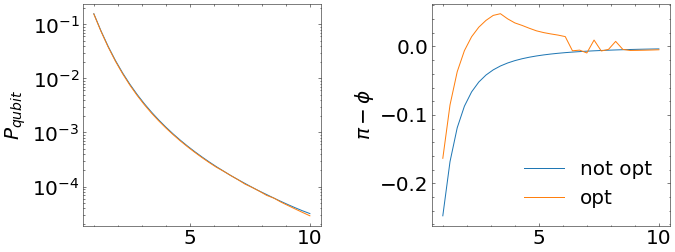

In [23]:
fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(10,4))
ax1.plot(all_η, 1-np.abs(new_phase_gate_30m_100MHz[:,-1]))
ax1.plot(all_η, 1-np.abs(new_phase_gate_30m_100MHz_opt[:,-1]))
ax1.set_yscale('log')
ax1.set_ylabel(r'$P_{qubit}$')
ax2.plot(all_η, np.angle(-new_phase_gate_30m_100MHz[:,1]/new_phase_gate_30m_100MHz[:,0]), label='not opt' )
ax2.plot(all_η, np.angle(-new_phase_gate_30m_100MHz_opt[:,1]/new_phase_gate_30m_100MHz_opt[:,0]), label = 'opt' )
ax2.set_ylabel(r'$\pi-\phi$')
fig.tight_layout()
ax2.legend()

In [26]:
if os.path.exists('../Data/new_phase_gate_5m_100MHz.npy'):
    new_phase_gate_5m_100MHz = np.load('../Data/new_phase_gate_5m_100MHz.npy')
    new_phase_gate_5m_100MHz_opt = np.load('../Data/new_phase_gate_5m_100MHz_opt.npy')
    all_η = np.load('../Data/new_phase_gate_5m_100MHz_eta.npy')
else:
    all_η = np.linspace(1, 10, 31)
    kappa = 2*pi*1e-3*100.0
    new_phase_gate_5m_100MHz = np.array(
        job(lambda η:
                scattering(δ1=2*π*8.416408398466828, δ2=2*π*8.416408398466828,
                           ω1=2*π*8.416408398466828, ω2=2*π*8.416408398466828,
                           κ1=kappa, κ2=kappa, χ=0.5*kappa, η=η,
                           lamb_shift=-0.012187088888888885*kappa,
                           Tfp=10, lwv=5, Nm=351, plot=False),
            all_η))
    np.save('../Data/new_phase_gate_5m_100MHz.npy', new_phase_gate_5m_100MHz)
    np.save('../Data/new_phase_gate_5m_100MHz_eta.npy', all_η)
    new_phase_gate_5m_100MHz_opt = np.array(
        job(lambda η:
                optimal_scattering(δ1=2*π*8.416408398466828, δ2=2*π*8.416408398466828,
                                   ω1=2*π*8.416408398466828, ω2=2*π*8.416408398466828,
                                   κ1=kappa, κ2=kappa, η=η, lamb_shift=-0.012187088888888885*kappa,
                                   Tfp=10, lwv=5, Nm=351),
            all_η)
    )
    np.save('../Data/new_phase_gate_5m_100MHz_opt.npy', new_phase_gate_5m_100MHz_opt)

Initial value of the control g_1(-tf)= (2π)*0.003522394480948118MHz
κ1 = (2π)*100.0MHz, κ2 = (2π)*100.0MHz, χ = 0.5*κ1, σ = 0.3846153846153846*κ1
Total time    =5.230510520749659*Propagation_time
η             =1.30
l             =5 m
|wv(tf)|^2    =0.01112
ωbar          =8.438504 (2π) GHz
ω2            =8.466408 (2π) GHz
success       =(0.9858661768524567, 0.9727231028393979)
1-F1          =0.0299564
1-F2          =0.0299564
overlap qubit =0.979273
angle qubit   =0.942852* π
overlap       =0.973362
angle         =0.939008 * π
tdelay        =56.391
emission time =4.022
Initial value of the control g_1(-tf)= (2π)*0.002513580398307873MHz
κ1 = (2π)*100.0MHz, κ2 = (2π)*100.0MHz, χ = 0.5*κ1, σ = 0.2631578947368421*κ1
Total time    =6.666292974416173*Propagation_time
η             =1.90
l             =5 m
|wv(tf)|^2    =0.00309
ωbar          =8.437923 (2π) GHz
ω2            =8.466408 (2π) GHz
success       =(0.9957958738121394, 0.9922954872281282)
1-F1          =0.00831466
1-F2          =0.0

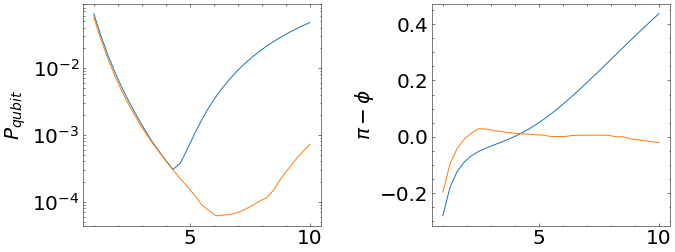

In [28]:
fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(10,4))
ax1.plot(all_η, 1-np.abs(new_phase_gate_5m_100MHz[:,-1]))
ax1.plot(all_η, 1-np.abs(new_phase_gate_5m_100MHz_opt[:,-1]))
ax1.set_yscale('log')
ax1.set_ylabel(r'$P_{qubit}$')
ax2.plot(all_η, np.angle(-new_phase_gate_5m_100MHz[:,1]/new_phase_gate_5m_100MHz[:,0]))
ax2.plot(all_η, np.angle(-new_phase_gate_5m_100MHz_opt[:,1]/new_phase_gate_5m_100MHz_opt[:,0]))
ax2.set_ylabel(r'$\pi-\phi$')
fig.tight_layout()

In [16]:
if os.path.exists('new_phase_gate_5m_50MHz.npy'):
    new_phase_gate_5m_50MHz = np.load('new_phase_gate_5m_50MHz.npy')
    new_phase_gate_5m_50MHz_opt = np.load('new_phase_gate_5m_50MHz_opt.npy')
    all_η = np.load('new_phase_gate_5m_50MHz_eta.npy')
else:
    all_η = np.linspace(1, 10, 31)
    kappa = 2*pi*1e-3*50.0
    new_phase_gate_5m_50MHz = np.array(
        job(lambda η:
                scattering(δ1=2*π*8.416408398466828, δ2=2*π*8.416408398466828,
                           ω1=2*π*8.416408398466828, ω2=2*π*8.416408398466828,
                           κ1=kappa, κ2=kappa, χ=0.5*kappa, η=η,
                           lamb_shift=-0.012187088888888885*kappa,
                           Tfp=10, lwv=5, Nm=351, plot=False),
            all_η))
    np.save('new_phase_gate_5m_50MHz.npy', new_phase_gate_5m_50MHz)
    np.save('new_phase_gate_5m_50MHz_eta.npy', all_η)
    new_phase_gate_5m_50MHz_opt = np.array(
        job(lambda η:
                optimal_scattering(δ1=2*π*8.416408398466828, δ2=2*π*8.416408398466828,
                                   ω1=2*π*8.416408398466828, ω2=2*π*8.416408398466828,
                                   κ1=kappa, κ2=kappa, η=η, lamb_shift=-0.012187088888888885*kappa,
                                   Tfp=10, lwv=5, Nm=351),
            all_η)
    )
    np.save('new_phase_gate_5m_50MHz_opt.npy', new_phase_gate_5m_50MHz_opt)

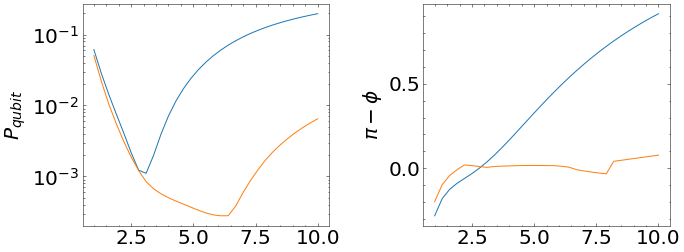

In [17]:
fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(10,4))
ax1.plot(all_η, 1-np.abs(new_phase_gate_5m_50MHz[:,-1]))
ax1.plot(all_η, 1-np.abs(new_phase_gate_5m_50MHz_opt[:,-1]))
ax1.set_yscale('log')
ax1.set_ylabel(r'$P_{qubit}$')
ax2.plot(all_η, np.angle(-new_phase_gate_5m_50MHz[:,1]/new_phase_gate_5m_50MHz[:,0]))
ax2.plot(all_η, np.angle(-new_phase_gate_5m_50MHz_opt[:,1]/new_phase_gate_5m_50MHz_opt[:,0]))
ax2.set_ylabel(r'$\pi-\phi$')
fig.tight_layout()

In [18]:
if os.path.exists('new_phase_gate_30m_50MHz.npy'):
    new_phase_gate_30m_50MHz = np.load('new_phase_gate_30m_50MHz.npy')
    new_phase_gate_30m_50MHz_opt = np.load('new_phase_gate_30m_50MHz_opt.npy')
    all_η = np.load('new_phase_gate_30m_50MHz_eta.npy')
else:
    all_η = np.linspace(1, 10, 31)
    kappa = 2*pi*1e-3*50.0
    new_phase_gate_30m_50MHz = np.array(
        job(lambda η:
                scattering(δ1=2*π*8.416408398466828, δ2=2*π*8.416408398466828,
                           ω1=2*π*8.416408398466828, ω2=2*π*8.416408398466828,
                           κ1=kappa, κ2=kappa, χ=0.5*kappa, η=η,
                           lamb_shift=-0.012187088888888885*kappa,
                           Tfp=10, lwv=30, Nm=2101, plot=False),
            all_η))
    np.save('new_phase_gate_30m_50MHz.npy', new_phase_gate_30m_50MHz)
    np.save('new_phase_gate_30m_50MHz_eta.npy', all_η)
    new_phase_gate_30m_50MHz_opt = np.array(
        job(lambda η:
                optimal_scattering(δ1=2*π*8.416408398466828, δ2=2*π*8.416408398466828,
                                   ω1=2*π*8.416408398466828, ω2=2*π*8.416408398466828,
                                   κ1=kappa, κ2=kappa, η=η, lamb_shift=-0.012187088888888885*kappa,
                                   Tfp=10, lwv=30, Nm=2101),
            all_η)
    )
    np.save('new_phase_gate_30m_50MHz_opt.npy', new_phase_gate_30m_50MHz_opt)

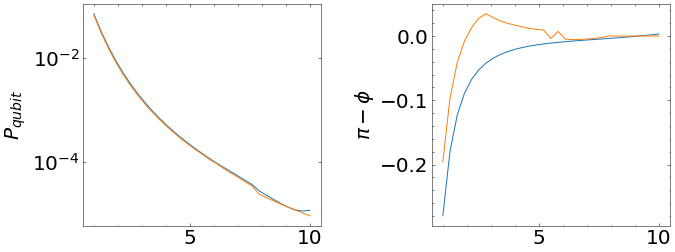

In [19]:
fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(10,4))
ax1.plot(all_η, 1-np.abs(new_phase_gate_30m_50MHz[:,-1]))
ax1.plot(all_η, 1-np.abs(new_phase_gate_30m_50MHz_opt[:,-1]))
ax1.set_yscale('log')
ax1.set_ylabel(r'$P_{qubit}$')
ax2.plot(all_η, np.angle(-new_phase_gate_30m_50MHz[:,1]/new_phase_gate_30m_50MHz[:,0]))
ax2.plot(all_η, np.angle(-new_phase_gate_30m_50MHz_opt[:,1]/new_phase_gate_30m_50MHz_opt[:,0]))
ax2.set_ylabel(r'$\pi-\phi$')
fig.tight_layout()

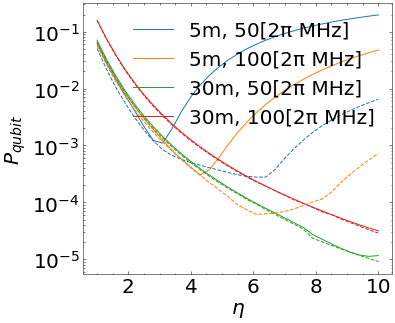

In [20]:
fig, ax1 = plt.subplots(ncols=1, figsize=(6,5))
p1 = ax1.plot(all_η, 1-np.abs(new_phase_gate_5m_50MHz[:,-1]), label='5m, 50[2π MHz]')
p3 = ax1.plot(all_η, 1-np.abs(new_phase_gate_5m_100MHz[:,-1]), label='5m, 100[2π MHz]')
p2 = ax1.plot(all_η, 1-np.abs(new_phase_gate_30m_50MHz[:,-1]), label='30m, 50[2π MHz]')
p4 = ax1.plot(all_η, 1-np.abs(new_phase_gate_30m_100MHz[:,-1]), label='30m, 100[2π MHz]')
ax1.plot(all_η, 1-np.abs(new_phase_gate_5m_50MHz_opt[:,-1]), '--', color=p1[0].get_color())
ax1.plot(all_η, 1-np.abs(new_phase_gate_30m_50MHz_opt[:,-1]), '--', color=p2[0].get_color())
ax1.plot(all_η, 1-np.abs(new_phase_gate_5m_100MHz_opt[:,-1]), '--', color=p3[0].get_color())
ax1.plot(all_η, 1-np.abs(new_phase_gate_30m_100MHz_opt[:,-1]), '--', color=p4[0].get_color())
ax1.set_yscale('log')
ax1.set_ylabel(r'$P_{qubit}$')
ax1.set_xlabel(r'$\eta$')
ax1.legend()
fig.tight_layout()

# Theoretical model

In [21]:
def sech_photon2(ω, κ):
    γ4 = 1/np.cosh(π*ω/κ)*1/κ**0.5
    γ4 *= np.sqrt(π/2)
    γ4 = γ4/(γ4@γ4)**(0.5)
    return γ4

In [22]:
def input_output_estimation(all_η, κ=2*π*1e-3*100, ω=2*π*8.40701933547913, lwv=30, mmax=2101):
    control = setup.Exp2QB2Cavities(ω1=ω, ω2=ω, δ2=0, g2=0, κ1=0, κ2 = 2*π*1e-3*100, l=lwv, mmax=mmax)
    z_e = np.zeros(all_η.size, dtype=np.complex128)
    z_g = np.zeros(all_η.size, dtype=np.complex128)
    
    for i, η in enumerate(all_η):
        κ = κ
        χ = κ/2
        ω = control.ωrelevant
        Ω = control.ω1
        Ω_e = Ω+κ/2
        Ω_g = Ω-κ/2
        ω_linear = control.ω1-(control.mcentral*π/lwv - control.mrelevant*π/lwv)*lwv/control.tprop
    
        Ψ = sech_photon2(ω-Ω, κ/η)
        ref = Ψ*np.exp(-1j*(π/2 + (2/κ)*(ω-Ω)))*np.exp(-1j*2*control.tprop*(ω_linear))
        
        e_real = Ψ*((-1j*(ω-(Ω_e))+(0.5*κ))/(-1j*(ω-(Ω_e))-(0.5*κ)))*np.exp(-1j*2*control.tprop*(ω))
        g_real = Ψ*((-1j*(ω-(Ω_g))+(0.5*κ))/(-1j*(ω-(Ω_g))-(0.5*κ)))*np.exp(-1j*2*control.tprop*(ω))
        
        z_e[i] = np.vdot(ref, e_real)
        z_g[i] = np.vdot(ref, g_real)

    return phase_gate_fidelity_asim(z_e, z_g)

In [23]:
F_30m_100MHz_theory = input_output_estimation(all_η, κ=2*π*1e-3*100, lwv=30, mmax=2101)
F_30m_50MHz_theory = input_output_estimation(all_η, κ=2*π*1e-3*50, lwv=30, mmax=2101)
F_5m_100MHz_theory = input_output_estimation(all_η, κ=2*π*1e-3*100, lwv=5, mmax=351)
F_5m_50MHz_theory = input_output_estimation(all_η, κ=2*π*1e-3*50, lwv=5, mmax=351)

/tmp/ipykernel_141/963474414.py:2: RuntimeWarning: overflow encountered in cosh
  γ4 = 1/np.cosh(π*ω/κ)*1/κ**0.5


In [24]:
def input_output_estimation_improved(κ=2*π*1e-3*100, ηmax=10, npoints=42, ω=2*π*8.40701933547913, l=30, mmax=2101):
    modulus_e = []
    modulus_g = []
    ϕ_e = [] 
    ϕ_g = []
    z_e = []
    z_g = []
    z_e_test = []
    control = setup.Exp2QB2Cavities(ω1=ω, ω2=ω, δ2=0, g2=0, κ1=0, κ2 = 2*π*1e-3*100, l=l, mmax=mmax)

    for η in np.linspace(1,ηmax,npoints):
        κ = κ
        χ = κ/2
        ω = control.ωrelevant
        Ω = control.ω1
        Ω_e = Ω+κ/2
        Ω_g = Ω-κ/2
        ω_linear = control.ω1-(control.mcentral*π/l - control.mrelevant*π/l)*l/control.tprop
        
        e_ref = sech_photon2(ω-Ω, κ/η)*np.exp(-1j*(π/2 + (2/κ)*(ω-Ω)))*np.exp(-1j*2*control.tprop*(ω_linear))
        
        g_ref = sech_photon2(ω-Ω, κ/η)*np.exp(-1j*(-π/2 + (2/κ)*(ω-Ω)))*np.exp(-1j*2*control.tprop*(ω_linear))
        
        
        e_real = sech_photon2(ω-Ω, κ/η)*((-1j*(ω-(Ω_e))+(0.5*κ))/(-1j*(ω-(Ω_e))-(0.5*κ)))*np.exp(-1j*2*control.tprop*(ω))
        
        g_real =  sech_photon2(ω-Ω, κ/η)*((-1j*(ω-(Ω_g))+(0.5*κ))/(-1j*(ω-(Ω_g))-(0.5*κ)))*np.exp(-1j*2*control.tprop*(ω))
        
        z_e.append(e_ref.conjugate()@e_real)
        z_g.append(g_ref.conjugate()@g_real)
        
        z_e_test.append(e_ref@g_ref.conjugate())
    z_e = np.array(z_e)
    z_g = np.array(z_g)
    return np.abs(z_e), np.abs(z_g), np.angle(z_e), np.angle(z_g)

In [26]:
def phase_gate_fidelity_asim2(z_e, z_g, φ):
    Fidelity = []
    for i in range(len(z_e)):
        r = np.abs(z_g[i])/np.abs(z_e[i])
        if (1+r*np.cos(φ[i]))/(1+r**2+2*r*np.cos(φ[i])) <= 1:
            Fidelity.append((np.abs(z_g[i])**2*np.sin(φ[i])**2)/(1+r**2+2*r*np.cos(φ[i])))
        else:
            Fidelity.append(np.abs(z_g[i])**2)
    return np.array(Fidelity)

In [27]:
z_e, z_g, φ_e, φ_g = input_output_estimation_improved(κ=2*π*1e-3*100, ηmax=10, npoints=42, ω=2*π*8.40701933547913, l=30, mmax=2101)
F_30m_100MHz_theory = phase_gate_fidelity_asim2(z_g, z_e, φ = π+(φ_e-φ_g))
z_e, z_g, φ_e, φ_g = input_output_estimation_improved(κ=2*π*1e-3*100, ηmax=10, npoints=42, ω=2*π*8.416408398466828, l=5, mmax=351)
F_5m_100MHz_theory = phase_gate_fidelity_asim2(z_g, z_e, φ = π+(φ_e-φ_g))
z_e, z_g, φ_e, φ_g = input_output_estimation_improved(κ=2*π*1e-3*50, ηmax=10, npoints=42, ω=2*π*8.40701933547913, l=30, mmax=2101)
F_30m_50MHz_theory = phase_gate_fidelity_asim2(z_g, z_e, φ = π+(φ_e-φ_g))
z_e, z_g, φ_e, φ_g = input_output_estimation_improved(κ=2*π*1e-3*50, ηmax=10, npoints=42, ω=2*π*8.416408398466828, l=5, mmax=351)
F_5m_50MHz_theory = phase_gate_fidelity_asim2(z_g, z_e, φ = π+(φ_e-φ_g))

/tmp/ipykernel_141/963474414.py:2: RuntimeWarning: overflow encountered in cosh
  γ4 = 1/np.cosh(π*ω/κ)*1/κ**0.5
/tmp/ipykernel_141/529378868.py:5: RuntimeWarning: divide by zero encountered in double_scalars
  if (1+r*np.cos(φ[i]))/(1+r**2+2*r*np.cos(φ[i])) <= 1:


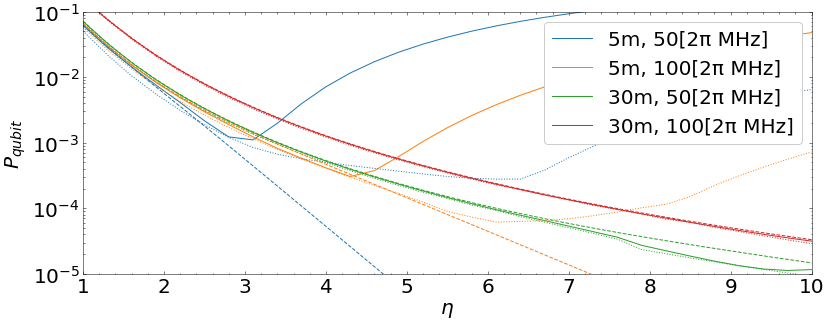

In [28]:
F_30m_100MHz_theoryb =np.load('F_30m_100MHz_theory.npy')
fig, ax1 = plt.subplots(ncols=1, figsize=(12,5))
p1 = ax1.plot(all_η, 1-np.abs(new_phase_gate_5m_50MHz[:,-1]), label='5m, 50[2π MHz]')
p3 = ax1.plot(all_η, 1-np.abs(new_phase_gate_5m_100MHz[:,-1]), label='5m, 100[2π MHz]')
p2 = ax1.plot(all_η, 1-np.abs(new_phase_gate_30m_50MHz[:,-1]), label='30m, 50[2π MHz]')
p4 = ax1.plot(all_η, 1-np.abs(new_phase_gate_30m_100MHz[:,-1]), label='30m, 100[2π MHz]')
if True:
    ax1.plot(all_η, 1-np.abs(new_phase_gate_5m_50MHz_opt[:,-1]), ':', color=p1[0].get_color())
    ax1.plot(all_η, 1-np.abs(new_phase_gate_5m_100MHz_opt[:,-1]), ':', color=p3[0].get_color())
    ax1.plot(all_η, 1-np.abs(new_phase_gate_30m_50MHz_opt[:,-1]), ':', color=p2[0].get_color())
    ax1.plot(all_η, 1-np.abs(new_phase_gate_30m_100MHz_opt[:,-1]), ':', color=p4[0].get_color())
if False:
    ax1.plot(all_η, 1-np.abs(F_5m_50MHz_theory), '--', color=p1[0].get_color())
    ax1.plot(all_η, 1-np.abs(F_30m_50MHz_theory), '--', color=p2[0].get_color())
    ax1.plot(all_η, 1-np.abs(F_5m_100MHz_theory), '--', color=p3[0].get_color())
    ax1.plot(all_η, 1-np.abs(F_30m_100MHz_theory), '--', color=p4[0].get_color())
else:
    ax1.plot(np.linspace(1,10,42), 1-np.abs(F_5m_50MHz_theory), '--', color=p1[0].get_color())
    ax1.plot(np.linspace(1,10,42), 1-np.abs(F_30m_50MHz_theory), '--', color=p2[0].get_color())
    ax1.plot(np.linspace(1,10,42), 1-np.abs(F_5m_100MHz_theory), '--', color=p3[0].get_color())
    ax1.plot(np.linspace(1,10,42), 1-np.abs(F_30m_100MHz_theory), '--', color=p4[0].get_color())
ax1.set_yscale('log')
ax1.set_ylim([1e-5,0.1])
ax1.set_xlim([1,10])
ax1.set_ylabel(r'$P_{qubit}$')
ax1.set_xlabel(r'$\eta$')
ax1.legend(facecolor='w',framealpha=1.0,frameon=True,loc='upper right')
fig.tight_layout()

2.9849329017567983


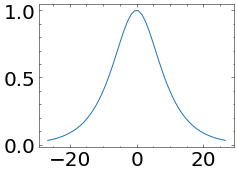

l=5, κ2=2π*0.05 -> η <= 0.46789059701234215
5.9698658035135965


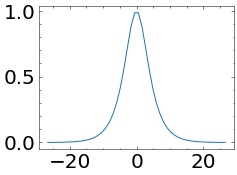

l=5, κ2=2π*0.1 -> η <= 0.8857823930627359
17.909597410540783


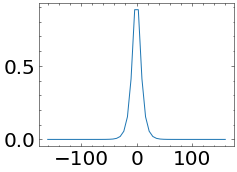

l=30, κ2=2π*0.05 -> η <= 2.5573447408913665
35.81919482108157


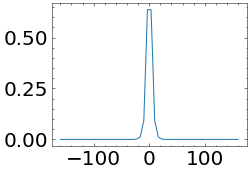

l=30, κ2=2π*0.1 -> η <= 5.064687740778047


In [29]:
def max_η(lwv=5, Nm=351, ω=2*π*8.416408398466828, κ=2*π*50e-3, Tfp=10):
    control = setup.Exp2QB2Cavities(ω1=ω, ω2=ω, δ2=0, g2=0, κ1=κ, κ2=κ, l=lwv, mmax=Nm)

    def cost(η):
        tdelay = 2*control.tprop + 2/κ
        duration = 2*Tfp/(κ/(2*η))
        return np.abs(tdelay - duration)
    
    print(control.tprop * κ / 2.8)
    t = np.linspace(-control.tprop, control.tprop)
    plt.plot(t, 1/np.cosh(κ*t/2.0))
    plt.show()

    ηmax, *_ = scipy.optimize.fminbound(cost, 0, 30, full_output=True)
    print(f'l={lwv}, κ2=2π*{κ/(2*π)} -> η <= {ηmax}')

max_η(lwv=5, Nm=351, κ=2*π*50e-3)
max_η(lwv=5, Nm=351, κ=2*π*100e-3)
max_η(lwv=30, Nm=2101, κ=2*π*50e-3)
max_η(lwv=30, Nm=2101, κ=2*π*100e-3)